# Preprocessing

*** scRNA pipline ***

Single-cell RNAseq pipeline involves Normalization, Scaling, PCA, UMAP, clustering. 

*** LLM ***

1. By LLM we could figure out the batch effect or Sex effect in the dataset. 
2. Specific cofounder like mitochondria, ribosomal gene effect in a particular cluster

May be during data Curation we need to download the metadata too in order to take into the effects

Interesting we can use anthropic or openAI image call that can look into the graph and identify if the batch has been properly corrected or not if it is not then it has to write it again with better batch correction 

To create a function, we have to run the code and then we will make the whole function

In [9]:
import os
import tarfile
import scanpy as sc
import pandas as pd
from pathlib import Path
import json
import re
import shutil
import gzip


In [10]:

tar_path = "/mnt/data/projects/.immune/Personal/scRNA_Agent/Data_Curator/geo_downloads/GSE301650_supplementary.tar"
out_dir = "/mnt/data/projects/.immune/Personal/scRNA_Agent/Data_Curator/geo_downloads/processed/"
tar_path = Path(tar_path)
out_dir = Path(out_dir)
out_dir.mkdir(parents=True, exist_ok=True)

extract_dir = out_dir / tar_path.stem
extract_dir.mkdir(exist_ok=True)

    # 1️⃣ Extract TAR
with tarfile.open(tar_path) as tar:
    tar.extractall(extract_dir)

    # 2️⃣ Detect GSM samples
files = list(extract_dir.glob("*.gz"))
pattern = re.compile(
    r"(GSM\d+)_.*_(matrix|features|barcodes)\.tsv\.gz|"
    r"(GSM\d+)_.*_matrix\.mtx\.gz")

sample_files = {}
for f in files:
    match = re.match(r"(GSM\d+)_.*_(matrix|features|barcodes)", f.name)
    if not match:
        continue
    gsm = match.group(1)
    sample_files.setdefault(gsm, []).append(f)

if not sample_files:
    raise ValueError("No GSM-level 10x files detected")

adatas = []


In [11]:
# 3️⃣ Build 10x directories per GSM
for gsm, flist in sample_files.items():
    gsm_dir = extract_dir / gsm
    gsm_dir.mkdir(exist_ok=True)

    for f in flist:
        if "matrix" in f.name:
            target = gsm_dir / "matrix.mtx.gz"
        elif "features" in f.name:
            target = gsm_dir / "features.tsv.gz"
        elif "barcodes" in f.name:
            target = gsm_dir / "barcodes.tsv.gz"
        else:
            continue
        shutil.copy(f, target)

    # 4️⃣ Load sample
    ad = sc.read_10x_mtx(
        gsm_dir,
        var_names="gene_symbols",
        cache=False
        )
    ad.obs["sample"] = gsm
    adatas.append(ad)


In [12]:
# 5️⃣ Merge samples
adata = sc.concat(adatas, label="sample", keys=[a.obs["sample"][0] for a in adatas])
    
# Adding Mitochondria and Ribosomal Genes 
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.upper().str.startswith(("RPS", "RPL"))

sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt", "ribo"],
    percent_top=None,
    log1p=False,
    inplace=True
    )

# 6️⃣ Standard preprocessing
# Cell filtering
adata = adata[
    (adata.obs.n_genes_by_counts > 200) &
    (adata.obs.n_genes_by_counts < 6000) &
    (adata.obs.pct_counts_mt < 15),
    :
    ]

# Gene filtering
adata = adata[:, adata.var.n_cells_by_counts > 3]
adata.raw = adata.copy()

/var/tmp/ipykernel_108827/3481755078.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata = sc.concat(adatas, label="sample", keys=[a.obs["sample"][0] for a in adatas])
/mnt/data/tools/miniconda3/envs/rapids_singlecell_gpu/lib/python3.11/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/mnt/data/tools/miniconda3/envs/rapids_singlecell_gpu/lib/python3.11/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)


/mnt/data/tools/miniconda3/envs/rapids_singlecell_gpu/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/mnt/data/tools/miniconda3/envs/rapids_singlecell_gpu/lib/python3.11/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/mnt/data/tools/miniconda3/envs/rapids_singlecell_gpu/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/var/tmp/ipykernel_108827/2154274607.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In [17]:
adata

AnnData object with n_obs × n_vars = 86074 × 2000
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [15]:
print(adata.raw.X.shape, adata.X.shape)

(86074, 25878) (86074, 2000)


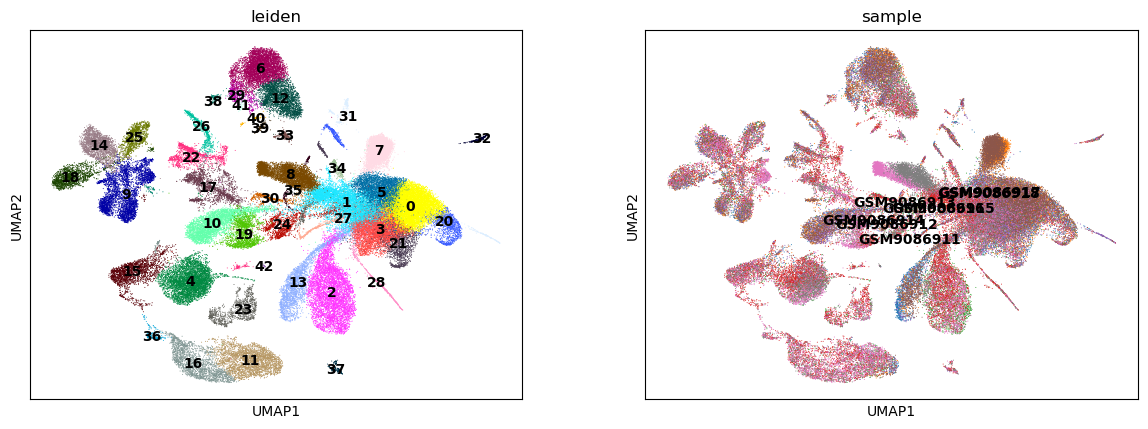

In [16]:
sc.pl.umap(
    adata,
    color=["leiden","sample"],
    # Setting a smaller point size to get prevent overlap
    legend_loc = "on data",
    size=2,
)

# Making a function

Combining all the code into the function

In [ ]:
import os
import tarfile
import scanpy as sc
import pandas as pd
from pathlib import Path
import json
import re
import shutil
import gzip

def scrna_preprocess_geo_tar(
    tar_path: str,
    out_dir: str = "processed"
) -> str:
    """
    Preprocess GEO supplementary TAR with multiple GSM-level 10x matrices.
    """

    tar_path = Path(tar_path)
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    extract_dir = out_dir / tar_path.stem
    extract_dir.mkdir(exist_ok=True)

    # 1️⃣ Extract TAR
    with tarfile.open(tar_path) as tar:
        tar.extractall(extract_dir)

    # 2️⃣ Detect GSM samples
    files = list(extract_dir.glob("*.gz"))
    pattern = re.compile(r"(GSM\d+)_.*_(matrix|features|barcodes)\.tsv\.gz|"
                         r"(GSM\d+)_.*_matrix\.mtx\.gz")

    sample_files = {}
    for f in files:
        match = re.match(r"(GSM\d+)_.*_(matrix|features|barcodes)", f.name)
        if not match:
            continue
        gsm = match.group(1)
        sample_files.setdefault(gsm, []).append(f)

    if not sample_files:
        raise ValueError("No GSM-level 10x files detected")

    adatas = []

    # 3️⃣ Build 10x directories per GSM
    for gsm, flist in sample_files.items():
        gsm_dir = extract_dir / gsm
        gsm_dir.mkdir(exist_ok=True)

        for f in flist:
            if "matrix" in f.name:
                target = gsm_dir / "matrix.mtx.gz"
            elif "features" in f.name:
                target = gsm_dir / "features.tsv.gz"
            elif "barcodes" in f.name:
                target = gsm_dir / "barcodes.tsv.gz"
            else:
                continue
            shutil.copy(f, target)

        # 4️⃣ Load sample
        ad = sc.read_10x_mtx(
            gsm_dir,
            var_names="gene_symbols",
            cache=False
        )
        ad.obs["sample"] = gsm
        adatas.append(ad)

    # 5️⃣ Merge samples
    adata = sc.concat(adatas, label="sample", keys=[a.obs["sample"][0] for a in adatas])
    
    # Adding Mitochondria and Ribosomal Genes 
    adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
    adata.var["ribo"] = adata.var_names.str.upper().str.startswith(("RPS", "RPL"))

    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=["mt", "ribo"],
        percent_top=None,
        log1p=False,
        inplace=True
    )

    # 6️⃣ Standard preprocessing
    # Cell filtering
    adata = adata[
        (adata.obs.n_genes_by_counts > 200) &
        (adata.obs.n_genes_by_counts < 6000) &
        (adata.obs.pct_counts_mt < 15),
        :
    ]

    # Gene filtering
    adata = adata[:, adata.var.n_cells_by_counts > 3]
    adata.raw = adata.copy() # backing up the raw counts
    
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
    adata = adata[:, adata.var.highly_variable]

    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=["leiden","sample"], legend_loc = "on data",size=2)

    out_h5ad = out_dir / f"{tar_path.stem}.h5ad"
    adata.write(out_h5ad)

    return json.dumps({
        "status": "success",
        "samples_detected": list(sample_files.keys()),
        "n_samples": len(sample_files),
        "n_cells": adata.n_obs,
        "n_genes": adata.n_vars,
        "output_h5ad": str(out_h5ad)
    }, indent=2)


In [28]:
scrna_preprocess_geo_tar(
    tar_path = "/mnt/data/projects/.immune/Personal/scRNA_Agent/Data_Curator/geo_downloads/GSE301650_supplementary.tar",
    out_dir = "/mnt/data/projects/.immune/Personal/scRNA_Agent/Data_Curator/geo_downloads/processed/"
)

/var/tmp/ipykernel_41288/230542216.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata = sc.concat(adatas, label="sample", keys=[a.obs["sample"][0] for a in adatas])
/mnt/data/tools/miniconda3/envs/rapids_singlecell_gpu/lib/python3.11/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/mnt/data/tools/miniconda3/envs/rapids_singlecell_gpu/lib/python3.11/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/mnt/data/tools/miniconda3/envs/rapids_singlecell_gpu/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Receive

'{\n  "status": "success",\n  "samples_detected": [\n    "GSM9086916",\n    "GSM9086917",\n    "GSM9086911",\n    "GSM9086912",\n    "GSM9086915",\n    "GSM9086918",\n    "GSM9086914",\n    "GSM9086913"\n  ],\n  "n_samples": 8,\n  "n_cells": 86074,\n  "n_genes": 2000,\n  "output_h5ad": "/mnt/data/projects/.immune/Personal/scRNA_Agent/Data_Curator/geo_downloads/processed/GSE301650_supplementary.h5ad"\n}'

In [ ]:
# load adata
# conda activate rapids_singlecell_gpu
import scanpy as sc
adata = sc.read_h5ad("/mnt/data/projects/.immune/Personal/scRNA_Agent/Data_Curator/geo_downloads/processed/GSE301650_supplementary.h5ad")

# Batch Correction
Now Agent has to check whether is a batch correction required by going multiple checks. 
1. Silhouette score
2. Cluster–batch entropy
3. Marker redundancy across batches
4. Technical dominance penalty

<p> 1. Silhouette score </p>

| Entropy     | Meaning                     |
| ----------- | --------------------------- |
| Low (<0.3)  | Strong batch separation     |
| 0.1–0.3     | Moderate                    |
| < 0.1       | Negligible                  |


<p> 2. Cluster–batch entropy </p>

| Entropy     | Meaning                     |
| ----------- | --------------------------- |
| Low (<0.5)  | Batch-dominated clusters    |
| Medium      | Mixed                       |
| High (>0.8) | Well mixed                  |


<p> 3. Marker redundancy across batches  </p>

1. Compute markers per cluster
2. Compute Jaccard overlap of top markers
3. Penalize high overlap between clusters dominated by different batches


In [24]:
# 1. Silhouette score
from sklearn.metrics import silhouette_score

def batch_silhouette(adata, rep="X_pca", batch_key="sample"):
    labels = adata.obs[batch_key]
    return silhouette_score(adata.obsm[rep], labels)


In [25]:
# 2. Cluster batch entropy
import numpy as np
from scipy.stats import entropy

def cluster_batch_entropy(adata, cluster_key="leiden", batch_key="sample"):
    entropies = []
    for c in adata.obs[cluster_key].unique():
        sub = adata.obs[adata.obs[cluster_key] == c]
        counts = sub[batch_key].value_counts(normalize=True)
        entropies.append(entropy(counts))
    return np.mean(entropies)


In [26]:
# 3. Marker redundancy across batches
def marker_overlap_score(cluster_markers):
    # cluster_markers: dict cluster → set(genes)
    overlaps = []
    clusters = list(cluster_markers.keys())
    for i in range(len(clusters)):
        for j in range(i+1, len(clusters)):
            a = cluster_markers[clusters[i]]
            b = cluster_markers[clusters[j]]
            overlaps.append(len(a & b) / len(a | b))
    return np.mean(overlaps)

In [27]:
# 4. Technical dominance penalty
def technical_driver_score(adata, cluster_key="leiden"):
    tech_vars = ["pct_counts_mt", "total_counts"]
    scores = []
    for var in tech_vars:
        corr = adata.obs.groupby(cluster_key)[var].mean().std()
        scores.append(corr)
    return np.mean(scores)

In [28]:
def integration_decider(adata):
    """
    Decide whether dataset integration is required.
    Returns a JSON-serializable dict.
    """

    from sklearn.metrics import silhouette_score
    import numpy as np
    from scipy.stats import entropy

    reasons = []
    score = 0

    # --- Rule 1: Batch silhouette ---
    if "X_pca" in adata.obsm and "sample" in adata.obs:
        sil = silhouette_score(
            adata.obsm["X_pca"],
            adata.obs["sample"]
        )
    else:
        sil = 0

    if sil > 0.3:
        score += 2
        reasons.append("Strong batch separation in PCA space")

    # --- Rule 2: Cluster-batch entropy ---
    entropies = []
    if "leiden" in adata.obs:
        for c in adata.obs["leiden"].unique():
            sub = adata.obs[adata.obs["leiden"] == c]
            counts = sub["sample"].value_counts(normalize=True)
            entropies.append(entropy(counts))
        mean_entropy = float(np.mean(entropies))
    else:
        mean_entropy = 1.0

    if mean_entropy < 0.5:
        score += 2
        reasons.append("Clusters dominated by single batches")

    # --- Rule 3: Technical driver check ---
    tech_vars = []
    if "pct_counts_mt" in adata.obs:
        tech_vars.append("pct_counts_mt")
    if "total_counts" in adata.obs:
        tech_vars.append("total_counts")

    tech_score = 0
    if tech_vars:
        tech_score = np.mean([
            adata.obs.groupby("leiden")[v].mean().std()
            for v in tech_vars
        ])

    if tech_score > 1.0:
        score += 1
        reasons.append("Clusters driven by technical covariates")

    integrate = score >= 3

    return {
        "integration_required": integrate,
        "confidence": round(min(score / 5, 1.0), 2),
        "reasons": reasons,
        "recommended_method": (
            "scvi" if integrate and adata.n_obs > 50000
            else "harmony" if integrate
            else "none"
        ),
        "metrics": {
            "batch_silhouette": round(float(sil), 3),
            "cluster_entropy": round(float(mean_entropy), 3),
            "technical_score": round(float(tech_score), 3),
        }
    }


In [29]:
def run_integration(adata, method="harmony"):
    if method == "harmony":
        import scanpy.external as sce
        sce.pp.harmony_integrate(adata, "sample")
        sc.pp.neighbors(adata, use_rep="X_pca_harmony")
    elif method == "scvi":
        import scvi
        scvi.model.SCVI.setup_anndata(adata, batch_key="sample")
        model = scvi.model.SCVI(adata)
        model.train()
        adata.obsm["X_scvi"] = model.get_latent_representation()
        sc.pp.neighbors(adata, use_rep="X_scvi")

    sc.tl.leiden(adata)
    sc.tl.umap(adata)
    print("Integration Complete")
    return adata


In [34]:
AGENT_SYSTEM_PRMOPT = """
You are a single-cell RNA-seq analysis agent.

You MUST NOT decide whether integration is needed yourself.

Rules:
- Always call the integration_decider tool after preprocessing
- Decide next steps ONLY from tool output
- If integration_required == true:
    - Explain why
    - Call the integration_runner tool
- If integration_required == false:
    - Proceed without integration
- Do not override tool decisions
- Do not visually inspect UMAPs

Tool call formats (EXACT):

{
  "tool_call": {
    "name": "integration_decider",
    "arguments": {
     "adata": "..."
    }
  }
}

{
  "tool_call": {
    "name": "run_integration",
    "arguments": {}
  }
}

"""

In [ ]:
## Loading a Qwen model
# conda activate torch_gpu_dna
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_id = "Qwen/Qwen2.5-7B-Instruct"
## KimiK2 thinking cannot be downloaded so we start with Qwen. Also my GPU is Tesla T4 so I will stick to Qwen-7B.

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16, # load_in_4bit=True does not work since python version should 3.8-3.10
    device_map="cuda"
)

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


In [31]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear(in_features=3584, out_features=3584, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((3584,), eps=1e-06)
    (ro

In [36]:
import json

def run_agent(prompt, max_steps=3):
    messages = [
        {"role": "system", "content": AGENT_SYSTEM_PRMOPT},
        {"role": "user", "content": prompt},
    ]

    for step in range(max_steps):
        print(f"\n--- Step {step} ---")

        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )

        model_inputs = tokenizer(inputs, return_tensors="pt").to(model.device)

        with torch.no_grad():
            output_ids = model.generate(
                **model_inputs,
                max_new_tokens=256,
                do_sample=False,
            )

        response = tokenizer.decode(
            output_ids[0][model_inputs["input_ids"].shape[-1]:],
            skip_special_tokens=True
        ).strip()

        print("LLM OUTPUT:\n", response)

        # Try parsing tool call
        try:
            data = json.loads(response)
            tool_call = data.get("tool_call")
        except json.JSONDecodeError:
            return response

        if not tool_call:
            return response

        tool_name = tool_call["name"]

        if tool_name == "integration_decider":
            result = integration_decider(adata)
        elif tool_name == "run_integration":
            result = run_integration(adata)
        else:
            raise ValueError(f"Unknown tool: {tool_name}")

        print("TOOL RESULT:\n", result)

        # Append assistant + tool messages
        messages.append({"role": "assistant", "content": response})
        messages.append({
            "role": "tool",
            "name": tool_name,
            "content": result
        })

    return "Agent stopped without conclusion"


In [37]:
final_output = run_agent(
    "Preprocessing is complete. Decide whether integration is required."
)

print("\nFINAL OUTPUT:\n", final_output)



--- Step 0 ---


LLM OUTPUT:
 {
  "tool_call": {
    "name": "integration_decider",
    "arguments": {
      "adata": "..."
    }
  }
}


/var/tmp/ipykernel_108827/3361399126.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby("leiden")[v].mean().std()


TOOL RESULT:
 {'integration_required': False, 'confidence': 0.2, 'reasons': ['Clusters driven by technical covariates'], 'recommended_method': 'none', 'metrics': {'batch_silhouette': -0.079, 'cluster_entropy': 1.618, 'technical_score': 3044.997}}

--- Step 1 ---
LLM OUTPUT:
 Since integration is not required as per the decision made by the integration_decider tool, I will proceed without integration.

Next steps will involve analyzing the preprocessed data directly.

FINAL OUTPUT:
 Since integration is not required as per the decision made by the integration_decider tool, I will proceed without integration.

Next steps will involve analyzing the preprocessed data directly.
